In [1]:
import tensorflow as tf
import numpy as np


class ResidualConv(tf.keras.Model):
    def __init__(self, filters, kernel_size, activation=tf.nn.relu, **kwargs):
        super().__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.c1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', **kwargs)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.c2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', **kwargs)
        self.activation = activation
        
    @tf.function
    def call(self, x, training=False):
        y = self.activation(self.c1(self.bn1(x, training=training), training=training))
        y = self.activation(self.c2(self.bn2(y, training=training), training=training))
        return y + x

def round_even(x):
    if x % 2 == 0:
        return x + 1
    else:
        return x + 2
    
class ConvRegressor(tf.keras.Model):
    def __init__(
        self, filters, kernel_size, 
        conv_type=tf.keras.layers.Conv2D, activation=tf.nn.relu, 
        **kwargs
    ):
        super().__init__()
        self.filters = filters
        self.conv_type = conv_type
        self.convs = []
        for n_filter in filters:
            self.convs.append(
                conv_type(n_filter, round_even(kernel_size), strides=2, padding='SAME', activation=activation, **kwargs)
            )
            self.convs.append(conv_type(n_filter, kernel_size, padding='SAME', activation=activation, **kwargs))
        self.convs.append(tf.keras.layers.Conv2D(n_filter, kernel_size, padding='SAME'))

    @tf.function
    def call(self, x, training=False):
        y = x
        for conv in self.convs:
            y = conv(y, training=training)
        return y

class ResidualConvRegressor(tf.keras.Model):
    def __init__(
        self, filters, out_ch, kernel_size, n_freq_residual=1, 
        conv_type=tf.keras.layers.Conv2D, activation=tf.nn.relu, 
        **kwargs
    ):
        super().__init__()
        self.filters = filters
        self.n_freq_residual = n_freq_residual
        self.conv_type = conv_type
        self.convs = []
        for n_filter in filters:
            self.convs.append(
                conv_type(
                    n_filter, round_even(kernel_size), strides=2, 
                    activation=activation, padding='SAME', **kwargs)
            )
            for i in range(n_freq_residual):
                self.convs.append(
                    ResidualConv(n_filter, kernel_size, activation=activation, **kwargs)
                )
        self.convs.append(tf.keras.layers.Conv2D(out_ch, kernel_size, padding='SAME'))

    @tf.function
    def call(self, x, training=False):
        y = x
        for conv in self.convs:
            y = conv(y, training=training)
        return y
    

In [2]:
fold_index = 0
task = 'home'
model_dir = './model'
model_type = 'cnn'

In [8]:
from pathlib import Path
model_dir = Path(model_dir)
model_dir.mkdir(exist_ok=True, parents=True)

In [9]:
# Load training setup
import pandas as pd
from pathlib import Path
import wavio
from tqdm.notebook import tqdm

root_dir = Path('evaluation_setup')

def get_annotation(task, fold_index, target):
    df = pd.read_csv(
        root_dir / f'{task}_fold{fold_index+1}_{target}.txt', sep='\t', 
        header=None, names=['file', 'class', 'start', 'end', 'event']
    )
    df['id'] = df['file'].apply(lambda x: Path(x).stem)
    return df

def load_dataset(target):
    df = get_annotation(task, fold_index, target)
    wav_dict = {}
    for file in tqdm(df['file'].unique()):
        wav_dict[Path(file).stem] = wavio.readwav(str(file))
    return df, wav_dict

df, wav_dict = load_dataset('train')

In [10]:
from itertools import product

sound_events = []

for fold, task_name in product([0,1,2,3], ['train', 'evaluate', 'test']):
    sound_events.extend(get_annotation('home', fold, task_name)['event'].unique())
sound_events = np.unique(sound_events)
print(sound_events)

['(object) rustling' '(object) snapping' 'cupboard' 'cutlery' 'dishes'
 'drawer' 'glass jingling' 'nan' 'object impact' 'people walking'
 'washing dishes' 'water tap running']


In [29]:
from functools import partial

def parse_wave(series, wav_dict):
    sr, bw, audio = wav_dict[series['id']]
    start = round(series['start'] * sr)
    end = round(series['end'] * sr)
    series['start_index'] = start
    series['end_index'] = end
    series['sr'] = sr
    series['bw'] = bw
    series['audio'] = audio[start:end]
    return series

audio_df = df.apply(partial(parse_wave, wav_dict=wav_dict), axis=1)

people walking


Text(0.5, 1.0, 'Audio length')

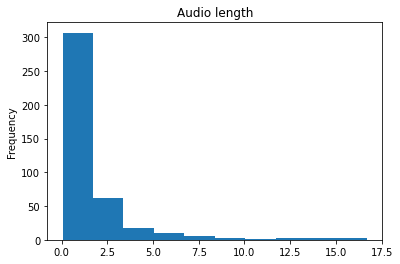

In [12]:
from IPython.display import Audio
series = audio_df.loc[0]
display(
    Audio(
        series['audio'][:, 0], 
        rate=series['sr']
    )
)
print(series['event'])

ax = audio_df.apply(lambda x: len(x['audio']) / x['sr'], axis=1).plot.hist()
ax.set_title('Audio length')

In [197]:
from functools import partial
import librosa

n_mels = 128
n_sampling=4096
hop_length = n_sampling // 4
window='hann'
pad='constant'

def preprocess(wav, sampling_rate):
    return np.concatenate([
        mono_preprocess(wav[..., 0], sampling_rate)[..., np.newaxis],
        mono_preprocess(wav[..., 1], sampling_rate)[..., np.newaxis],
    ], axis=-1)
    
def mono_preprocess(wav, sampling_rate):
#     F = librosa.stft(wav, n_sampling, hop_length=hopsize, window=window, pad_mode=pad)
#     mag = np.abs(F)[..., np.newaxis]
#     phase = np.angle(F)[..., np.newaxis]
#     mag_phase = np.concatenate([mag, phase], axis=2)
    
    mag = librosa.feature.melspectrogram(
        wav, sr=sampling_rate, hop_length=hop_length, n_mels=n_mels,
        fmin=0.0, fmax=20e3,
    )
    logmag = np.log(mag + 1e8)
    return logmag

def normalize_time(audio_df, max_time):
#     max_time = max(
#         len(audio) / sr 
#         for audio, sr in zip(audio_df['audio'], audio_df['sr'])
#     )
    results = []
    for audio, sr in zip(audio_df['audio'], audio_df['sr']):
        max_len = int(sr * max_time)

        pos = min(len(audio), max_len)
        result = np.zeros((max_len, 2), np.float32)
        result[:pos, :] = audio[:pos]
        results.append(result)
    return results

def get_dataset(target):
    df, wav_dict = load_dataset(target)
    audio_df = df.apply(partial(parse_wave, wav_dict=wav_dict), axis=1)
    encoding_dict = {c: i for i, c in enumerate(sound_events)}

    normed_audio = normalize_time(audio_df, max_time=5.0)
    audios = np.concatenate([
        preprocess(audio, sr)[np.newaxis] 
        for audio, sr in tqdm(zip(normed_audio, audio_df['sr']), total=len(normed_audio))
    ], axis=0)
    
    events = audio_df['event'].replace({
        event: i for i, event in enumerate(sound_events)
    })
    
    return audios.astype(np.float32), events.to_numpy().astype(np.int32)

def get_tf_dataset(target, batch_size=32, shuffle=False):
    audio, events = get_dataset(target)
    ds = tf.data.Dataset.from_tensor_slices((audio, events)).batch(
        batch_size, drop_remainder=shuffle)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    return ds


In [37]:
train_dataset = get_tf_dataset('train')

C:\Users\kazbi\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


In [62]:
train_dataset = get_tf_dataset('train')
test_dataset = get_tf_dataset('evaluate')

In [198]:
from collections import defaultdict

class PlotCallback(tf.keras.callbacks.Callback):
    is_higher_better = {
        'accuracy'
    }
    is_linear = {
        'accuracy',
        'sparse_categorical_accuracy',
    }
    def __init__(self, targets=None, n_step=1):
        super().__init__()
        self.fig = None
        self.axes = None
        self.axes_index = {}
        self.n_step = n_step
        self.targets = targets
        self.epochs = []
        self.history = defaultdict(list)

    def plot_and_display(self):
        for ax in self.axes.flat:
            ax.clear()
        for i, (label, values) in enumerate(self.history.items()):
            if any(name in label for name in self.is_higher_better):
                get_best_value = np.amax
            else:
                get_best_value = np.amin
            
            if label.startswith('val_'):
                _label = label[4:]
            else:
                _label = label
            
            ax = self.axes.flat[self.axes_index[_label]]
            ax.plot(self.epochs, values, label=label, color=f'C{i}')
            best_value = get_best_value(values)
            ax.axhline(best_value, linestyle='--', color=f'C{i}')
            ax.text(0.0, best_value, f'{best_value:.3f}')
            
            if _label not in self.is_linear:
                ax.set_yscale('log')

        if self.epochs[-1] == 0:
            self.fig.legend()

        io = BytesIO()
        self.fig.savefig(io, format='png')

        clear_output(wait=True)
        display_png(Image(io.getvalue()))
        
    def on_epoch_end(self, epoch, logs):
        if epoch == 0:
            self.fig, self.axes = plt.subplots(len(logs) // 2, 1, figsize=(8, 4 * len(logs) // 2))
            self.axes_index = {}
            for label in logs:
                if label.startswith('val_'):
                    _label = label[4:]
                else:
                    _label = label
                if _label not in self.axes_index:
                    self.axes_index[_label] = len(self.axes_index)

        for key, value in logs.items():
            self.history[key].append(value)

        self.epochs.append(epoch)
        if (epoch % self.n_step) == 0:
            self.plot_and_display()
            
class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_path, monitor='val_loss', mode='min'):
        self.checkpoint_path = checkpoint_path
        self.monitor = monitor
        self.mode = mode
        
        self._best_value = None
        if self.mode == 'min':
            self.compare = min
        elif self.mode == 'max':
            self.compare = max
        
    def on_epoch_end(self, epoch, logs):
        value = logs[self.monitor]
        if self._best_value is None:
            self._best_value = value
            self.model.save_weights(self.checkpoint_path)
        self._best_value = self.compare(self._best_value, value)

In [199]:
image_shape = next(train_dataset.as_numpy_iterator())[0].shape
print(image_shape)

(32, 128, 216, 2)


In [236]:
def create_cnn_model():
    return tf.keras.Sequential([
        ConvRegressor([8, 16, 32, 64, 128, 256], kernel_size=7),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000, activation=tf.nn.relu),
        tf.keras.layers.Dense(1000, activation=tf.nn.relu),
        tf.keras.layers.Dense(len(sound_events)),
    ])

def create_resnet_cnn_model():
    return tf.keras.Sequential([
        ResidualConvRegressor(
            [8, 16, 32, 64, 128, 256], out_ch=256, kernel_size=7,
            n_freq_residual=3,
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000, activation=tf.nn.relu),
        tf.keras.layers.Dense(1000, activation=tf.nn.relu),
        tf.keras.layers.Dense(len(sound_events)),
    ])

if model_type == 'cnn':
    create_model = create_cnn_model
elif model_type == 'resnet':
    create_model = create_resnet_cnn_model
else:
    raise NotImplementedError()

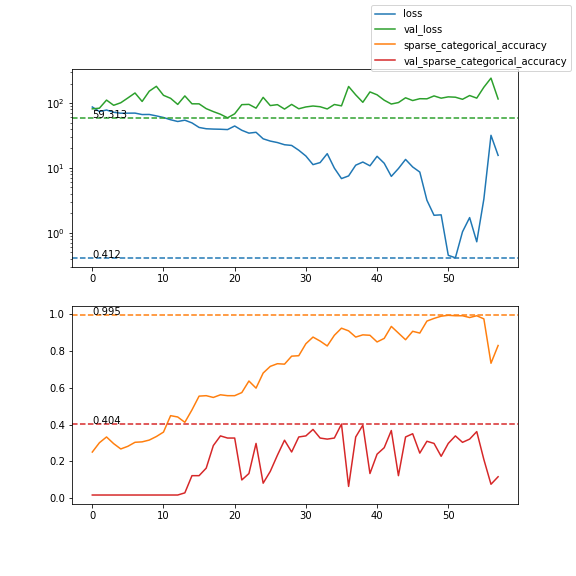

13/13 [==============================] - 1s 101ms/step - loss: 15.6270 - sparse_categorical_accuracy: 0.8309 - val_loss: 115.7941 - val_sparse_categorical_accuracy: 0.1170
Epoch 59/2000
13/13 [==============================] - 1s 89ms/step - loss: 8.5258 - sparse_categorical_accuracy: 0.8937 - val_loss: 160.7743 - val_sparse_categorical_accuracy: 0.2047
Epoch 60/2000
13/13 [==============================] - 1s 89ms/step - loss: 7.6375 - sparse_categorical_accuracy: 0.9155 - val_loss: 172.0646 - val_sparse_categorical_accuracy: 0.1871


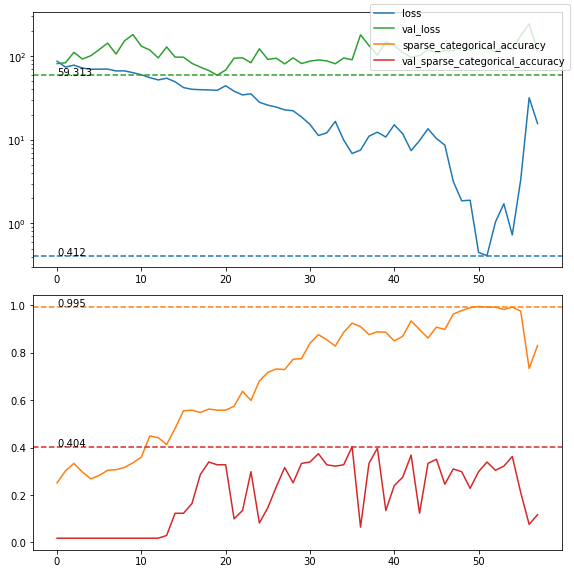

In [231]:
import IPython 
from collections import defaultdict 
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time
import seaborn as sns
from io import BytesIO
import imageio
from IPython.display import Image, display_png, clear_output

#%matplotlib widget
%matplotlib inline
#%matplotlib notebook
epochs = 2000
model_type = 'resnet'
model = create_model()
optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.99)

checkpoint_name = f'{task}_{model_type}_fold{fold_index}'
cur_model_dir = model_dir / checkpoint_name
cur_model_dir.mkdir(exist_ok=True, parents=True)

plot_callback = PlotCallback(n_step=3)
with tf.device('/GPU:0'):
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.SUM),
        optimizer=optimizer,
        metrics=tf.keras.metrics.sparse_categorical_accuracy,
    )
    
    mode = 'min'
    model.fit(
        train_dataset,
        batch_size=8, epochs=2000, shuffle=True,
        validation_data=test_dataset,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                patience=40, 
                #monitor='val_sparse_categorical_accuracy',
                monitor='val_loss',
                mode=mode
            ),
            plot_callback,
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.ModelCheckpoint(
                str(cur_model_dir / (checkpoint_name + '.model')),
                #monitor='val_sparse_categorical_accuracy', 
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,
                mode=mode, 
            )
        ]
    )

plot_callback.fig.tight_layout()
plot_callback.fig.savefig(str(cur_model_dir / (checkpoint_name + '.png')))

In [238]:
from itertools import product
from sklearn.metrics import accuracy_score
accuracy_data = []
model = create_model()
model.load_weights(str(cur_model_dir / (checkpoint_name + '.model')))
model.compile()

results = {}
for target_name, dataset in zip(['train', 'test'], [train_dataset, test_dataset]):
    pred_logits = model.predict(dataset)
    pred_labels = tf.argmax(tf.nn.softmax(pred_logits, axis=1), axis=1)

    truth_labels = []
    for batch in dataset:
        truth_labels.extend(batch[1].numpy())
    metric = tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(
        tf.convert_to_tensor(np.array(truth_labels).astype(np.int32)), 
        tf.convert_to_tensor(pred_logits.astype(np.float32))
    )).numpy()

    truth_labels = np.array(sound_events).take(truth_labels)
    pred_labels = np.array(sound_events).take(pred_labels)
    
    agg_df = pd.crosstab(
        pd.Series(truth_labels, name='Truth'),
        pd.Series(pred_labels, name='Prediction'),
    )
    agg_df = agg_df.reindex(columns=sound_events, index=sound_events, fill_value=0)
    display(target_name)
    display(agg_df)
    
    accuracy = {}
    for name in sound_events:
        mask = truth_labels == name
        accuracy[name] = accuracy_score(truth_labels[mask], pred_labels[mask]) 
    accuracy['Metric'] = metric
    accuracy_data.append(pd.Series(accuracy, name=target_name))
    
    results[target_name] = {
        'Prediction': pd.DataFrame({
            'Prediction': pred_labels,
            'Truth': truth_labels,
        }),
        'Agg': agg_df,
        'Accuracy': accuracy_data,
    }
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df['Mean'] = accuracy_df.mean(axis=1)
display(accuracy_df.T)

'train'

Prediction,(object) rustling,(object) snapping,cupboard,cutlery,dishes,drawer,glass jingling,nan,object impact,people walking,washing dishes,water tap running
Truth,,,,,,,,,,,,
(object) rustling,19,0,0,0,3,1,0,0,3,1,8,2
(object) snapping,5,0,0,0,1,2,0,0,11,0,11,0
cupboard,0,0,0,0,1,3,0,0,12,0,0,0
cutlery,10,0,0,7,0,2,0,0,2,0,26,5
dishes,8,0,0,0,17,15,0,0,17,0,1,1
drawer,1,0,0,0,0,15,0,0,5,0,1,0
glass jingling,3,0,0,0,2,2,2,0,6,0,4,2
nan,0,0,0,0,0,0,0,0,0,0,0,0
object impact,1,0,0,0,1,33,0,0,60,0,3,0


C:\Users\kazbi\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\kazbi\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


'test'

Prediction,(object) rustling,(object) snapping,cupboard,cutlery,dishes,drawer,glass jingling,nan,object impact,people walking,washing dishes,water tap running
Truth,,,,,,,,,,,,
(object) rustling,1,0,0,0,0,1,0,0,0,1,1,0
(object) snapping,0,0,0,0,1,2,0,0,6,0,3,0
cupboard,1,0,0,0,0,1,0,0,8,0,0,1
cutlery,0,0,0,1,0,1,0,0,1,0,1,0
dishes,2,0,0,1,4,14,0,0,10,0,0,4
drawer,0,0,0,0,1,0,0,0,0,0,0,0
glass jingling,0,0,0,0,0,1,0,0,3,0,0,1
nan,0,0,0,0,0,0,0,0,0,0,0,0
object impact,2,0,0,0,2,26,0,0,25,0,1,1


C:\Users\kazbi\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\kazbi\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,train,test
(object) rustling,0.513514,0.250000
(object) snapping,0.000000,0.000000
cupboard,0.000000,0.000000
cutlery,0.134615,0.250000
dishes,0.288136,0.114286
drawer,0.681818,0.000000
glass jingling,0.095238,0.000000
nan,NaN,NaN
object impact,0.612245,0.438596
people walking,0.500000,0.500000


In [239]:
import cloudpickle as pickle
with open(cur_model_dir / 'result_metrics.pickle', 'wb+') as fp:
    pickle.dump(results, fp)